In [1]:
import tensorflow as tf
print(f"Num Gpu Avaiable Are : {len(tf.config.list_physical_devices('GPU'))}")

Num Gpu Avaiable Are : 1


In [2]:
# Importing necessary libraries for deep learning and image processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import cv2
import os, glob
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D,GlobalAveragePooling2D,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


In [3]:
data_train = r"./dataset/train"
data_test = r"./dataset/test"
fake=[]
for file in os.listdir(data_test):
    if file[0] =='.':
        continue
    fake+=[file]
print(fake)
print(len(fake))

['Fake', 'Real']
2


In [4]:
# Setting up image data generators for training and testing datasets
# Using data augmentation to prevent overfitting

img_height,img_width=256,256
batch_size=20

# Generator for validation/test data
train_datagen = ImageDataGenerator(rescale=1./255)

# Load training datasets from directory
train_generator = train_datagen.flow_from_directory(data_train, # Path to training data directory
                                                target_size=(img_height,img_width), # Resize all images to 224x224
                                                batch_size=batch_size,
                                                class_mode='categorical', # classification (Fake vs Real)
                                               )

# Load testing datasets from directory
test_generator = train_datagen.flow_from_directory(data_test, # Path to training data directory
                                                target_size=(img_height,img_width), # Resize all images to 224x224
                                                batch_size=batch_size,
                                                class_mode='categorical', # classification (Fake vs Real)
                                               )

Found 64526 images belonging to 2 classes.
Found 5474 images belonging to 2 classes.


In [5]:
# These metrics help in evaluating the performance of the classification model.

precision=tf.keras.metrics.Precision() # Precision metric calculates the ratio of correctly predicted positive observations to the total predicted positives.
recall=tf.keras.metrics.Recall()  # Recall metric calculates the ratio of correctly predicted positive observations to all observations in actual class.

# Here, the metric is computed at a specificity of 0.1 (10% True Negative Rate).
sensitivity=tf.keras.metrics.SensitivityAtSpecificity(0.1) # Sensitivity is the ability of the model to identify true positives at a chosen specificity threshold.

# Here, the metric is computed at a sensitivity of 0.1 (10% True Positive Rate).
specificity=tf.keras.metrics.SpecificityAtSensitivity(0.1) # Specificity is the ability of the model to identify true negatives at a chosen sensitivity threshold.

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    Parameters:
    - y_true: Array of true labels.
    - y_pred: Array of predicted labels.
    - classes: List of class names for labeling the matrix.
    - normalize: Boolean, whether to apply normalization to the confusion matrix.
    - title: Optional string to set the title of the plot.
    - cmap: Colormap for visualizing the matrix.

    Returns:
    - ax: The axes object with the plot.
    """

    # If no title is provided, set default based on normalization
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix based on true and predicted labels
    cm = confusion_matrix(y_true, y_pred)

    # Keep only the class names that are used in the data
    classes = classes

    # If normalization is requested, convert the confusion matrix to percentages
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # Print the confusion matrix (normalized or raw)
    print(cm)

    # Create a new figure and axis for plotting
    fig, ax = plt.subplots()

    # Display the confusion matrix as an image
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)

    # Add a color bar next to the plot to show scale
    ax.figure.colorbar(im, ax=ax)

    # Set the x and y ticks to correspond to the number of classes
    ax.set(xticks=np.arange(cm.shape[1]),  # Set the x ticks to match number of columns
           yticks=np.arange(cm.shape[0]),  # Set the y ticks to match number of rows
           # Label x and y ticks with the respective class names
           xticklabels=classes, yticklabels=classes,
           title=title,  # Set the plot title
           ylabel='True label',  # Label for the y-axis
           xlabel='Predicted label')  # Label for the x-axis

    # Rotate the x-axis tick labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Format the values in the confusion matrix. If normalized, format as float; otherwise, as integer
    fmt = '.2f' if normalize else 'd'
    # Set a threshold to decide text color (white for values above half the max, black otherwise)
    thresh = cm.max() / 2.

    # Loop through each element of the matrix and annotate the plot with the value
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",  # Align text to the center of the cell
                    color="white" if cm[i, j] > thresh else "black")  # Text color based on threshold

    # Adjust the layout to fit the plot neatly
    fig.tight_layout()

    return ax  # Return the axis object for further customization if needed


## CNN

In [7]:
# Importing required layers from the Keras library
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# Initializing a Sequential model
model = Sequential()

# Adding the first Convolutional layer with 32 filters, a 5x5 kernel size, 
# 'Same' padding (to maintain the dimensions), 'relu' activation, 
# and specifying the input shape (img_height, img_width, 3) for RGB images
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', 
                 activation='relu', input_shape=(img_height, img_width, 3)))

# Adding another Convolutional layer with 32 filters and 5x5 kernel size,
# maintaining the same padding and using 'relu' activation
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', 
                 activation='relu'))

# Adding a Max Pooling layer with a 2x2 pool size, reducing the spatial 
# dimensions by half to reduce complexity and extract important features
model.add(MaxPool2D(pool_size=(2, 2)))

# Adding the third Convolutional layer with 64 filters and 3x3 kernel size,
# with 'Same' padding and 'relu' activation
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', 
                 activation='relu'))

# Adding another Convolutional layer with 64 filters and a 3x3 kernel size,
# using 'Same' padding and 'relu' activation again
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', 
                 activation='relu'))

# Adding another Max Pooling layer, reducing spatial dimensions again by half,
# with a pool size of 2x2 and strides of 2x2 (for down-sampling)
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# Flattening the 2D feature maps into a 1D vector to be input to the Dense layer
model.add(Flatten())

# Adding a fully connected (Dense) layer with 256 units and 'relu' activation
# to introduce non-linearity and learn complex patterns
model.add(Dense(256, activation='relu'))

# Adding the output layer with 2 units and 'softmax' activation for
# multi-class classification (assuming 2 classes for the fake/real image)
model.add(Dense(2, activation='softmax'))

# Summarizing the model to display the architecture and parameters
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0

In [8]:
# Compiling the model with 'adam' optimizer and 'categorical_crossentropy' as the loss function
# Metrics include accuracy, precision, recall, sensitivity, and specificity for better performance tracking.
model.compile(
    optimizer="adam",  # Adam optimizer for adaptive learning rate adjustment
    loss="categorical_crossentropy",  # Loss function suitable for classification
    metrics=['accuracy', precision, recall, sensitivity, specificity]  # Performance metrics
)

# Fitting the model to the training data
# Using 'train_generator' for training data and validating with 'test_generator' over 15 epochs
# 'train_generator' provides batches of training data with real-time data augmentation
# 'validation_data' specifies the test data generator for evaluating model performance after each epoch
hist = model.fit(
    train_generator,  # Training data with augmentation
    epochs=15,  # Number of epochs to train the model
    validation_data=test_generator  # Validation data to assess model performance during training
)

Epoch 1/15
3227/3227 [==============================] - 794s 240ms/step - loss: 0.6986 - accuracy: 0.5170 - precision: 0.5170 - recall: 0.5170 - sensitivity_at_specificity: 0.8912 - specificity_at_sensitivity: 0.8912 - val_loss: 0.6957 - val_accuracy: 0.4642 - val_precision: 0.4642 - val_recall: 0.4642 - val_sensitivity_at_specificity: 0.4642 - val_specificity_at_sensitivity: 0.4642
Epoch 2/15
3227/3227 [==============================] - 550s 171ms/step - loss: 0.6925 - accuracy: 0.5183 - precision: 0.5183 - recall: 0.5183 - sensitivity_at_specificity: 0.7705 - specificity_at_sensitivity: 0.7705 - val_loss: 0.6968 - val_accuracy: 0.4642 - val_precision: 0.4642 - val_recall: 0.4642 - val_sensitivity_at_specificity: 0.4642 - val_specificity_at_sensitivity: 0.4642
Epoch 3/15
3227/3227 [==============================] - 549s 170ms/step - loss: 0.6926 - accuracy: 0.5183 - precision: 0.5183 - recall: 0.5183 - sensitivity_at_specificity: 0.8997 - specificity_at_sensitivity: 0.8997 - val_loss:

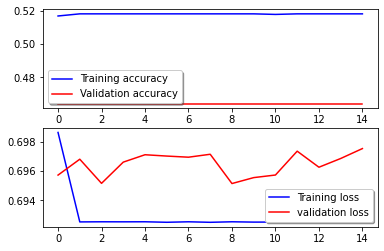

In [9]:
# Create a figure with 2 subplots (stacked vertically)
fig, ax = plt.subplots(2, 1)

# Plot the training and validation accuracy on the first subplot (ax[0])
ax[0].plot(hist.history['accuracy'], color='b', label="Training accuracy")  # Plot training accuracy in blue
ax[0].plot(hist.history['val_accuracy'], color='r', label="Validation accuracy")  # Plot validation accuracy in red
legend = ax[0].legend(loc='best', shadow=True)  # Display legend for accuracy with the best location and shadow effect

# Plot the training and validation loss on the second subplot (ax[1])
ax[1].plot(hist.history['loss'], color='b', label="Training loss")  # Plot training loss in blue
ax[1].plot(hist.history['val_loss'], color='r', label="Validation loss")  # Plot validation loss in red
legend = ax[1].legend(loc='best', shadow=True)  # Display legend for loss with the best location and shadow effect

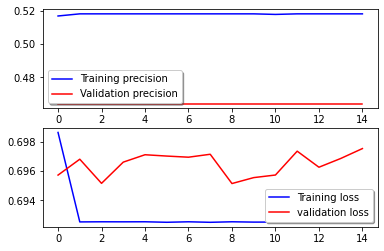

In [10]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['precision'], color='b', label="Training precision")
ax[0].plot(hist.history['val_precision'], color='r',label="Validation precision")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

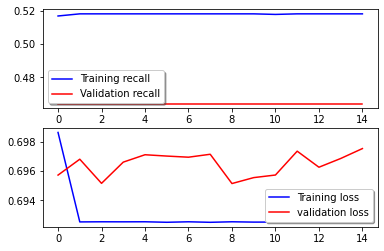

In [11]:
# Creating a figure with two subplots (2 rows, 1 column)
fig, ax = plt.subplots(2,1)

# Plotting the training precision on the first subplot
ax[0].plot(hist.history['precision'], color='b', label="Training precision")

# Plotting the validation precision on the first subplot
ax[0].plot(hist.history['val_precision'], color='r', label="Validation precision")

# Adding a legend to the first subplot for precision plots
legend = ax[0].legend(loc='best', shadow=True)

# Plotting the training loss on the second subplot
ax[1].plot(hist.history['loss'], color='b', label="Training loss")

# Plotting the validation loss on the second subplot
ax[1].plot(hist.history['val_loss'], color='r', label="Validation loss")

# Adding a legend to the second subplot for loss plots
legend = ax[1].legend(loc='best', shadow=True)

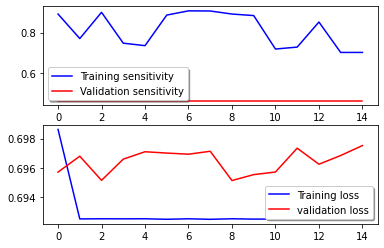

In [12]:
# Create a figure with two subplots (2 rows, 1 column)
fig, ax = plt.subplots(2,1)

# Plot the training recall on the first subplot (ax[0])
ax[0].plot(hist.history['recall'], color='b', label="Training recall")
# Plot the validation recall on the first subplot (ax[0])
ax[0].plot(hist.history['val_recall'], color='r', label="Validation recall")
# Add a legend to the first subplot, located at the best position, with a shadow effect
legend = ax[0].legend(loc='best', shadow=True)

# Plot the training loss on the second subplot (ax[1])
ax[1].plot(hist.history['loss'], color='b', label="Training loss")
# Plot the validation loss on the second subplot (ax[1])
ax[1].plot(hist.history['val_loss'], color='r', label="Validation loss")
# Add a legend to the second subplot, located at the best position, with a shadow effect
legend = ax[1].legend(loc='best', shadow=True)

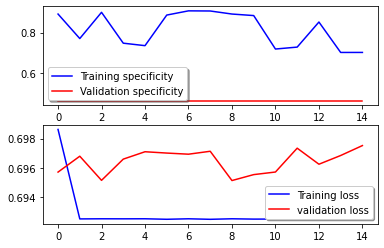

In [13]:
# Creating a figure and two subplots stacked vertically (2 rows, 1 column)
fig, ax = plt.subplots(2,1)

# Plotting training specificity (performance metric) on the first subplot
ax[0].plot(hist.history['specificity_at_sensitivity'], color='b', label="Training specificity")
# Plotting validation specificity on the same subplot
ax[0].plot(hist.history['val_specificity_at_sensitivity'], color='r', label="Validation specificity")
# Adding a legend to the first subplot to differentiate between the training and validation specificity
legend = ax[0].legend(loc='best', shadow=True)

# Plotting training loss on the second subplot
ax[1].plot(hist.history['loss'], color='b', label="Training loss")
# Plotting validation loss on the same subplot
ax[1].plot(hist.history['val_loss'], color='r', label="Validation loss")
# Adding a legend to the second subplot to differentiate between the training and validation loss
legend = ax[1].legend(loc='best', shadow=True)

In [14]:
# Saving the trained CNN model to a file in .h5 format
# This allows us to reuse the trained model later without retraining
model.save("./models/CNN.h5")

In [15]:
# Retrieve the list of filenames in the test generator
filenames = test_generator.filenames

# Get the total number of samples in the test set
nb_samples = len(filenames)

# Use the trained model to make predictions on the test set
# 'predict_generator' is used to generate predictions for the entire test set
# 'steps' argument is set to the total number of samples to ensure all data is covered
# 'verbose=2' provides more detailed output during the prediction process
model_predict = model.predict_generator(test_generator, steps=nb_samples, verbose=2)

c:\Users\0258\.conda\envs\deepfake\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


5474/5474 - 17s


Confusion matrix, without normalization
[[   0 2933]
 [   0 2541]]


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

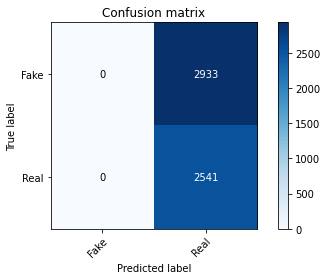

In [16]:
# Extract the true labels from the test data generator
y_true = test_generator.classes  # 'classes' attribute gives the true labels for each test sample

# Predict the class probabilities using the trained model and convert them to predicted class labels
y_pred = model_predict.argmax(axis=1)  # 'argmax' finds the index of the highest probability class (Fake or Real)

# Plot the confusion matrix for visualizing the performance of the classifier
# The confusion matrix will display the counts of True Positive, True Negative, False Positive, and False Negative
plot_confusion_matrix(y_true, y_pred, classes=['Fake', 'Real'], 
                      title='Confusion matrix')  # 'classes' specifies the class names, and 'title' sets the plot title

## VGG16

In [7]:
# Load the pre-trained VGG16 model without the top classification layer (include_top=False).
# Weights are pre-trained on ImageNet, and the input shape is set to (img_height, img_width, 3) 
# to match the image dimensions for this task.
base_model1 = tf.keras.applications.VGG16(input_shape=(img_height, img_width, 3), include_top=False,
                                          weights='imagenet')

# Initialize a Sequential model
model1 = Sequential()

# Add the VGG16 base model to the sequential model. 
# This will be used for feature extraction, with all convolutional layers pre-trained on ImageNet.
model1.add(base_model1)

# Add a Global Average Pooling layer. This converts the 2D feature maps into a single feature vector per image.
model1.add(GlobalAveragePooling2D())

# Add a Dense (fully connected) layer with 64 units and ReLU activation function for learning complex features.
model1.add(Dense(64, activation='relu'))

# Add a BatchNormalization layer to normalize the activations and speed up convergence.
model1.add(BatchNormalization())

# Add a Dropout layer with a rate of 0.2 to reduce overfitting by randomly dropping neurons during training.
model1.add(Dropout(0.2))

# Add the final Dense output layer with 2 units (for binary classification) and sigmoid activation.
# Sigmoid is used to output probabilities for each class.
model1.add(Dense(2, activation='sigmoid'))

# Print a summary of the model architecture, including the layers and their output shapes.
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 14,747,906
Trainable params: 14,747,778
Non-trainable params: 128
__________________________________________

In [8]:
# Compile the VGG16 model (model1) using the Adam optimizer
# Loss function: Categorical Crossentropy for multi-class classification
# Metrics: Accuracy, Precision, Recall, Sensitivity, and Specificity to evaluate performance
model1.compile(optimizer="adam", 
               loss="categorical_crossentropy", 
               metrics=['accuracy', precision, recall, sensitivity, specificity])

# Train the model on the training data (train_generator) for 15 epochs
# Validate the model's performance using the test data (test_generator) after each epoch
hist1 = model1.fit(train_generator, epochs=15, validation_data=test_generator)

# Save the trained VGG16 model to a file (vgg16.h5) in the 'models' directory for later use
model1.save("./models/vgg16.h5")

Epoch 1/15
3227/3227 [==============================] - 1006s 307ms/step - loss: 0.6772 - accuracy: 0.5833 - precision: 0.5550 - recall: 0.5450 - sensitivity_at_specificity: 0.9390 - specificity_at_sensitivity: 0.9364 - val_loss: 1.4824 - val_accuracy: 0.4750 - val_precision: 0.4928 - val_recall: 0.5930 - val_sensitivity_at_specificity: 0.9198 - val_specificity_at_sensitivity: 0.8533
Epoch 2/15
3227/3227 [==============================] - 857s 265ms/step - loss: 0.6341 - accuracy: 0.6528 - precision: 0.6332 - recall: 0.5184 - sensitivity_at_specificity: 0.9610 - specificity_at_sensitivity: 0.9644 - val_loss: 2.0221 - val_accuracy: 0.4642 - val_precision: 0.4673 - val_recall: 0.4744 - val_sensitivity_at_specificity: 0.9152 - val_specificity_at_sensitivity: 0.8782
Epoch 3/15
3227/3227 [==============================] - 861s 267ms/step - loss: 0.6538 - accuracy: 0.5967 - precision: 0.5908 - recall: 0.5796 - sensitivity_at_specificity: 0.9692 - specificity_at_sensitivity: 0.9695 - val_loss

In [ ]:
# Create a figure with two subplots (one for accuracy and one for loss)
fig, ax = plt.subplots(2, 1)

# Plot training and validation accuracy on the first subplot
ax[0].plot(hist1.history['accuracy'], color='b', label="Training accuracy")  # Plot training accuracy in blue
ax[0].plot(hist1.history['val_accuracy'], color='r', label="Validation accuracy")  # Plot validation accuracy in red
legend = ax[0].legend(loc='best', shadow=True)  # Add a legend to the first subplot showing the labels with shadow

# Plot training and validation loss on the second subplot
ax[1].plot(hist1.history['loss'], color='b', label="Training loss")  # Plot training loss in blue
ax[1].plot(hist1.history['val_loss'], color='r', label="Validation loss")  # Plot validation loss in red
legend = ax[1].legend(loc='best', shadow=True)  # Add a legend to the second subplot showing the labels with shadow

In [ ]:
# Create a figure and two subplots (stacked vertically)
fig, ax = plt.subplots(2,1)

# Plot the training and validation precision on the first subplot
ax[0].plot(hist1.history['precision'], color='b', label="Training precision")  # Plot training precision in blue
ax[0].plot(hist1.history['val_precision'], color='r',label="Validation precision")  # Plot validation precision in red
legend = ax[0].legend(loc='best', shadow=True)  # Add legend to the first subplot

# Plot the training and validation loss on the second subplot
ax[1].plot(hist1.history['loss'], color='b', label="Training loss")  # Plot training loss in blue
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")  # Plot validation loss in red
legend = ax[1].legend(loc='best', shadow=True)  # Add legend to the second subplot

In [ ]:
# Creating a figure and two subplots arranged vertically (2 rows, 1 column)
fig, ax = plt.subplots(2,1)

# Plotting training recall (y-axis) over epochs (x-axis) in blue on the first subplot
ax[0].plot(hist1.history['recall'], color='b', label="Training recall")

# Plotting validation recall (y-axis) over epochs (x-axis) in red on the first subplot
ax[0].plot(hist1.history['val_recall'], color='r', label="Validation recall")

# Adding a legend to the first subplot to identify the blue and red lines (training/validation recall)
legend = ax[0].legend(loc='best', shadow=True)

# Plotting training loss (y-axis) over epochs (x-axis) in blue on the second subplot
ax[1].plot(hist1.history['loss'], color='b', label="Training loss")

# Plotting validation loss (y-axis) over epochs (x-axis) in red on the second subplot
ax[1].plot(hist1.history['val_loss'], color='r', label="validation loss")

# Adding a legend to the second subplot to identify the blue and red lines (training/validation loss)
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
# Create a figure with 2 subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1)

# Plot the training sensitivity at specific specificity on the first subplot (ax[0])
ax[0].plot(hist1.history['sensitivity_at_specificity'], color='b', label="Training sensitivity")

# Plot the validation sensitivity at specific specificity on the first subplot (ax[0])
ax[0].plot(hist1.history['val_sensitivity_at_specificity'], color='r', label="Validation sensitivity")

# Add a legend to the first subplot, positioned at the best location, with shadow effect
legend = ax[0].legend(loc='best', shadow=True)

# Plot the training loss on the second subplot (ax[1])
ax[1].plot(hist1.history['loss'], color='b', label="Training loss")

# Plot the validation loss on the second subplot (ax[1])
ax[1].plot(hist1.history['val_loss'], color='r', label="Validation loss")

# Add a legend to the second subplot, positioned at the best location, with shadow effect
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
# Create a figure with 2 subplots arranged vertically (2 rows, 1 column)
fig, ax = plt.subplots(2, 1)

# Plot the training specificity on the first subplot (ax[0])
# 'specificity_at_sensitivity' refers to the metric tracked during training
ax[0].plot(hist1.history['specificity_at_sensitivity'], color='b', label="Training specificity")

# Plot the validation specificity on the first subplot (ax[0])
# 'val_specificity_at_sensitivity' refers to the metric tracked during validation
ax[0].plot(hist1.history['val_specificity_at_sensitivity'], color='r', label="Validation specificity")

# Add a legend to the first subplot to differentiate between the training and validation lines
legend = ax[0].legend(loc='best', shadow=True)

# Plot the training loss on the second subplot (ax[1])
# 'loss' refers to the loss tracked during training
ax[1].plot(hist1.history['loss'], color='b', label="Training loss")

# Plot the validation loss on the second subplot (ax[1])
# 'val_loss' refers to the loss tracked during validation
ax[1].plot(hist1.history['val_loss'], color='r', label="validation loss")

# Add a legend to the second subplot to differentiate between the training and validation lines
legend = ax[1].legend(loc='best', shadow=True)


In [ ]:
# Extracting the filenames from the test_generator, which contains the file paths of the images being processed
filenames = test_generator.filenames

# Calculating the total number of samples (images) in the test set
nb_samples = len(filenames)

# Using the trained model (model1) to make predictions on the test set
# predict_generator is used here to generate predictions for each image in the test set
# 'steps' is set to the number of samples to ensure that all images are processed
# verbose=2 provides detailed output during the prediction process
model1_predict = model1.predict_generator(test_generator, steps=nb_samples, verbose=2)

In [ ]:
# Get the true labels from the test generator
# These are the actual classes (0 or 1) for each sample in the test set
y_true = test_generator.classes

# Get the predicted labels from the model's predictions
# Using argmax to get the index of the maximum predicted value (0 for 'Fake' or 1 for 'Real')
y_pred = model1_predict.argmax(axis=1)

# Plot the confusion matrix to evaluate the classification results
# The confusion matrix compares true labels (y_true) with predicted labels (y_pred)
# 'classes' specifies the labels for the two categories: 'Fake' and 'Real'
# 'title' sets the title of the confusion matrix plot
plot_confusion_matrix(y_true, y_pred, classes=['Fake', 'Real'], title='Confusion matrix')

## MOBILENET

In [ ]:
# Load the pre-trained MobileNet model without the top layer (classification head)
# The input shape is specified according to the image height and width, with 3 channels (RGB)
# The weights are initialized from the ImageNet dataset
base_model = tf.keras.applications.MobileNet(input_shape=(img_height, img_width, 3), include_top=False,
                                             weights='imagenet')

# Initialize a sequential model
model8 = Sequential()

# Add the base MobileNet model to the sequential model
# This will serve as the feature extractor
model8.add(base_model)

# Add a Global Average Pooling layer to reduce the spatial dimensions of the feature maps
model8.add(GlobalAveragePooling2D())

# Add a fully connected dense layer with 64 units and ReLU activation for further learning
model8.add(Dense(64, activation='relu'))

# Add a Batch Normalization layer to stabilize and speed up training
model8.add(BatchNormalization())

# Add a Dropout layer with a 20% dropout rate to prevent overfitting
model8.add(Dropout(0.2))

# Add the final dense layer with 2 units and sigmoid activation for binary classification (e.g., Fake or Real)
model8.add(Dense(2, activation='sigmoid'))

# Print the summary of the model to display the architecture and parameter details
model8.summary()

In [ ]:
# Compiling the model using the Adam optimizer
# Loss function is categorical_crossentropy, used for multi-class classification
# Metrics to be monitored during training: accuracy, precision, recall, sensitivity, and specificity
model8.compile(optimizer="adam", 
               loss="categorical_crossentropy", 
               metrics=['accuracy', precision, recall, sensitivity, specificity])

# Training the model for 15 epochs using the train data generator and validating on the test data
hist8 = model8.fit(train_generator, 
                   epochs=15, 
                   validation_data=test_generator)

# Saving the trained model in .h5 format for later use
model8.save("./models/mobilenet.h5")

In [ ]:
# Create a figure and two subplots arranged vertically (2 rows, 1 column)
fig, ax = plt.subplots(2,1)

# Plot training and validation accuracy on the first subplot (ax[0])
ax[0].plot(hist8.history['accuracy'], color='b', label="Training accuracy")  # Plot training accuracy in blue
ax[0].plot(hist8.history['val_accuracy'], color='r', label="Validation accuracy")  # Plot validation accuracy in red
legend = ax[0].legend(loc='best', shadow=True)  # Add a legend for the accuracy plot in the best location

# Plot training and validation loss on the second subplot (ax[1])
ax[1].plot(hist8.history['loss'], color='b', label="Training loss")  # Plot training loss in blue
ax[1].plot(hist8.history['val_loss'], color='r', label="Validation loss", axes=ax[1])  # Plot validation loss in red
legend = ax[1].legend(loc='best', shadow=True)  # Add a legend for the loss plot in the best location

In [ ]:
# Creating a figure with 2 subplots (one for precision and one for loss)
fig, ax = plt.subplots(2,1)

# Plotting training precision on the first subplot
ax[0].plot(hist8.history['precision'], color='b', label="Training precision")
# Plotting validation precision on the first subplot
ax[0].plot(hist8.history['val_precision'], color='r', label="Validation precision")
# Adding a legend to the first subplot for better visualization
legend = ax[0].legend(loc='best', shadow=True)

# Plotting training loss on the second subplot
ax[1].plot(hist8.history['loss'], color='b', label="Training loss")
# Plotting validation loss on the second subplot
ax[1].plot(hist8.history['val_loss'], color='r', label="Validation loss", axes=ax[1])
# Adding a legend to the second subplot for better visualization
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
# Create a figure with two subplots (2 rows, 1 column) for recall and loss
fig, ax = plt.subplots(2,1)

# Plot training recall on the first subplot (ax[0]) in blue
ax[0].plot(hist8.history['recall'], color='b', label="Training recall")

# Plot validation recall on the first subplot (ax[0]) in red
ax[0].plot(hist8.history['val_recall'], color='r', label="Validation recall")

# Add a legend to the first subplot to label training and validation recall
legend = ax[0].legend(loc='best', shadow=True)

# Plot training loss on the second subplot (ax[1]) in blue
ax[1].plot(hist8.history['loss'], color='b', label="Training loss")

# Plot validation loss on the second subplot (ax[1]) in red
ax[1].plot(hist8.history['val_loss'], color='r', label="Validation loss")

# Add a legend to the second subplot to label training and validation loss
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
# Create a figure with 2 subplots (one for sensitivity and one for loss)
fig, ax = plt.subplots(2,1)

# Plot the training sensitivity at a specific specificity threshold on the first subplot
ax[0].plot(hist8.history['sensitivity_at_specificity'], color='b', label="Training sensitivity")

# Plot the validation sensitivity at a specific specificity threshold on the first subplot
ax[0].plot(hist8.history['val_sensitivity_at_specificity'], color='r', label="Validation sensitivity")

# Add a legend to the first subplot for better visualization of the lines
legend = ax[0].legend(loc='best', shadow=True)

# Plot the training loss on the second subplot
ax[1].plot(hist8.history['loss'], color='b', label="Training loss")

# Plot the validation loss on the second subplot
ax[1].plot(hist8.history['val_loss'], color='r', label="Validation loss")

# Add a legend to the second subplot for better visualization of the lines
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
# Creating a figure with two subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1)

# Plotting training specificity on the first subplot
ax[0].plot(hist8.history['specificity_at_sensitivity'], color='b', label="Training specificity")
# Plotting validation specificity on the first subplot
ax[0].plot(hist8.history['val_specificity_at_sensitivity'], color='r', label="Validation specificity")
# Adding a legend to the first subplot to differentiate training and validation lines
legend = ax[0].legend(loc='best', shadow=True)

# Plotting training loss on the second subplot
ax[1].plot(hist8.history['loss'], color='b', label="Training loss")
# Plotting validation loss on the second subplot
ax[1].plot(hist8.history['val_loss'], color='r', label="Validation loss", axes=ax[1])
# Adding a legend to the second subplot to differentiate training and validation lines
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
# Getting the filenames from the test data generator
filenames = test_generator.filenames

# Calculating the number of samples in the test set
nb_samples = len(filenames)

# Generating predictions for the test set using the trained model (model1)
# The predictions are made for the entire test set, and verbose=2 shows detailed progress information
model1_predict = model1.predict_generator(test_generator, steps=nb_samples, verbose=2)

In [ ]:
# 'y_true' contains the true class labels from the test set, extracted from the generator
y_true = test_generator.classes

# 'y_pred' contains the predicted class labels, derived from the model's predictions
# Using 'argmax' to convert the predicted probabilities to class labels (0 or 1)
y_pred = model1_predict.argmax(axis=1)

# Plotting the confusion matrix to visualize the performance of the model
# 'classes' defines the class labels, i.e., 'Fake' and 'Real'
# The 'title' parameter specifies the title of the confusion matrix plot
plot_confusion_matrix(y_true, y_pred, classes=['Fake', 'Real'], 
                      title='Confusion matrix')